# **SPARC training school on Climate Data Analysis and Artificial Intelligence**
# Forecasting ENSO using a linear regression, random forests, and a Convolutional Neural Network

This tutorial is adapted from [this](https://colab.research.google.com/drive/1eLEYFK3Mrae_nu1SzAjg7Sdf40bWnKTg#scrollTo=12Pzw4pM1Fhs&forceEdit=true&sandboxMode=true) excellent notebook developed by Ankur Mahesh (UC Berkeley) for the Climate Change and AI Summer School 2023.

#Setup/ Logistics


*   **Sharing**: Based on sharing permissions, you should not be allowed to make edits to the shared Colab notebook directly.  In order to make edits to this notebook, you should press File > "Save a Copy in Drive". This will ensure that any edits will be on your local copy, and they will not affect the notebook shared with everyone else.
*   **Participation**: this notebook includes a variety of ways to participate, including "fill-in-the-blank" code cells, discussion questions, and long-form challenge exercises.  Please work through these alone or in groups during the session following your own pace and/or interests.
*   **Scaffold code** : this notebook is also meant to serve as an example of the data loading and preprocessing necessary to work with climate data and machine learning.  Please read the "docstring" to familiarize yourself with important methods, such as `assemble_predictors_predictands`, and what they do.  You are also strongly encouraged to read through the code in the methods themselves, to understand the data preprocessing steps in detail.



## Introduction

El Niño–Southern Oscillation (ENSO) is a quasi-periodic variability mode observed in the tropical winds and sea surface temperatures (SSTs) over the Pacific ocean. The ocean component of the oscillation is characterized by warmer or colder than average conditions in the tropical Pacific. The warm phase (characterized by high sea temperature anomalies) is known as El Niño and the oposite cool phase, La Niña. The state of this oscillation measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.

Because El Niño is tied to many weather patterns around the world, such as the Indian monsoon, hurricanes in the Atlantic, and North American temperature, accurate ENSO forecasts are valuable for climate-sensitive sectors (such as agriculture, water, and energy).Existing El Niño forecasts utilize dynamical models, from the European Center for Medium-range Weather Forecasts and the National Center for Environmental Prediction. These dynamical models issue forecasts by modeling the physics of the atmosphere and ocean.  In this notebook, we will issue ENSO forecasts using machine learning.

Here we will focus on the ocean component, in particular we will train an algorithm to predict the phase of an ENSO index given the full field of SST field of the previous months.










## Software Requirements

This notebook requires the following libraries: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.  Furthermore, it is recommended that you use this notebook on Google Colab for ease of use and for access to GPU resources.

In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Data



*   [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): this is a dataset of historical sea surface temperatures form 1880 to 2018
*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies.




### Input Variables

Sea surface temperature (K)

### Output Variables

Nino3.4 index (K): this metric indicates the state of ENSO.



### Training Set

Baseline training set: Training on **1980-1995 sea Surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 months)

### Validation Set
**1997-2006 sea surface temperatures** and their corresponding Nino3.4 Index at lead times.

### Test Set:

Test on **2007-2017 sea surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 month).

In [ ]:
#Download the required packages and the data that we will use
#for this tutorial

!pip install netCDF4
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
# !wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00


In [ ]:
#Download Nino3.4 index (this index measures the state of ENSO by encoding the average
#temperature anomaly in the equatorial Pacific)
!gdown --id 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t
To: /content/nino34.long.anom.data.txt
100% 15.4k/15.4k [00:00<00:00, 39.7MB/s]


In [ ]:
#Download sst observations from 1880 to 2018
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

Downloading...
From: https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
To: /content/sst.mon.mean.trefadj.anom.1880to2018.nc
100% 432M/432M [00:02<00:00, 199MB/s]


In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time,
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]

  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    #TODO: create an option to apply the PCA operation learned
    #on the train set to the test set.  Currently, PCA is performed
    #independently on the train set and test set.
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead,
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()

def plot_nino_time_series_comparison(y, predictions_1, predictions_2, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions_1 np.array  : time series of the predicted Nino index (same
                            length and time as y)
    predictions_2 np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions_1 = pd.Series(predictions_1, index=y.index)
  predictions_1 = predictions_1.sort_index()
  predictions_2 = pd.Series(predictions_2, index=y.index)
  predictions_2 = predictions_2.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions_1, '--', label='ML Predictions 1')
  plt.plot(predictions_2, '--', label='ML Predictions 2')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()



# Background: Importance of Train/Validation/Test Set and Overfitting

A machine learning model uses statistical optimization to learn the relationship between predictors (the input) and predictands (the label).  
*   At this workshop, our predictors have been anomalized global temperature, and our predictand has been the El Nino/ Southern Oscillation (ENSO) 3.4 Index at a lead time.  

Let's call our predictors $X$, and let's call our predictand $y$.  There is some unknown relationship between $X$ and $y$.  For example, there is some unknown function governing the relationship between global temperature and the future ENSO index.  The goal of an ML model is to *approximate* this unknown function.

How do we test if the ML model has correctly approximated this function?  We divide the data into a train set and a test set.


*   During training, the ML model is shown the predictors and their associated predictands.  The ML model uses optimization to learn a function: given the training predictors, the function outputs the predictands as closely as possible.
*   During testing, the ML model is evaluated on unseen data (i.e. the test set). When a model performs well on the training set and poorly on the test, the model has **overfit** to the train set.
*   If a model performs poorly on the training set, this behavior is called **underfitting**.  During underfitting, the model has not learned the correct relationship between the predictors and the predictand.



***Question***: In the image below, which image corresponds to overfitting? Which corresponds to underfitting? And which corresponds to neither?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)




The code cell below explores overfitting: getting great performance on the train set.
For an absurd lead time (36 months!!), it is possible to get a perfect correlation on the train set.  Such accurate forecasting at such large lead times is almost certainly impossible.


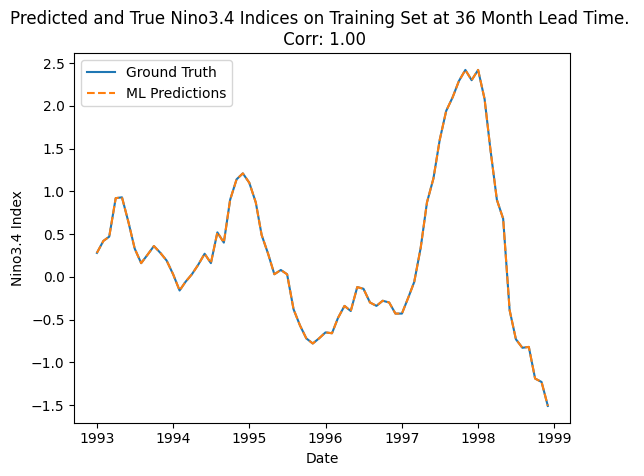

In [ ]:
#Load in the predictors
X, y = assemble_basic_predictors_predictands('1990-01-01','1995-12-31', 36)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

The cell above shows that getting great train-set performance is possible, even for a very tough task (36 month ahead Nino forecast).
We need to evaluate the model on unseen data to see if it can **generalize** well: this is why a test set is so crucial!


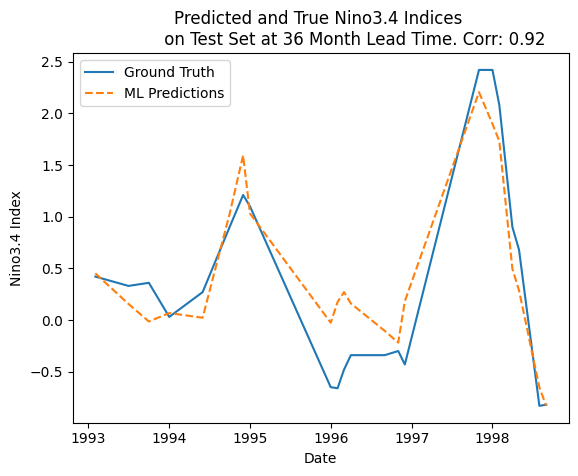

In [ ]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

What happened above? Did we just develop a 36-month ahead forecast that has 0.81 correlation on unseen data??

Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.  Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.  

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

**Extra Question:** Will performance on a true, uncorrelated test set be better or worse than performance on the biased dataset (when correlation was 0.81)?

In [ ]:
"""Exercise: write code to explore the above additional question"""


'Exercise: write code to explore the above additional question'

After your work on the previous exercise, check your understanding.  On a true test set, does the model making *36 month ahead* predictions generalize well?

***Extra Question***: For longer lead times, would model performance improve or worsen?

In [ ]:
"""Exercise: write code to explore the above additional question"""

'Exercise: write code to explore the above additional question'

# Baseline Method

The baseline model will be a linear regression. We evaluate this model using the Root Mean Squared Error (RMSE) and Pearson correlation coefficient. The code cell above includes code to calculate these two metrics, so that we can later use them to compare this model against the more advanced ones.

In [ ]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


RMSE: 0.28


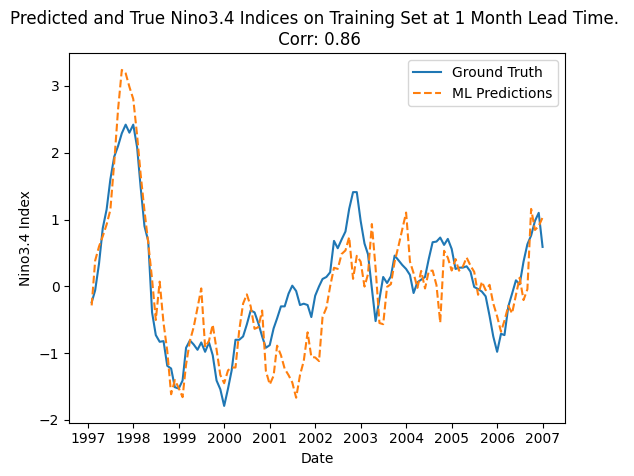

In [ ]:
#Let's use a linear regression model
l_regr = sklearn.linear_model.LinearRegression()
l_regr.fit(X_train,y_train)

l_predictions = l_regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(l_predictions, y_val)
rmse = mean_squared_error(y_val, l_predictions)
print("RMSE: {:.2f}".format(rmse))


plot_nino_time_series(y_val, l_predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

# Random Forest and gradient boosting

We train an advanced machine learning model: a [random forest model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for predicting the ENSO index one month ahead.

RMSE: 0.09


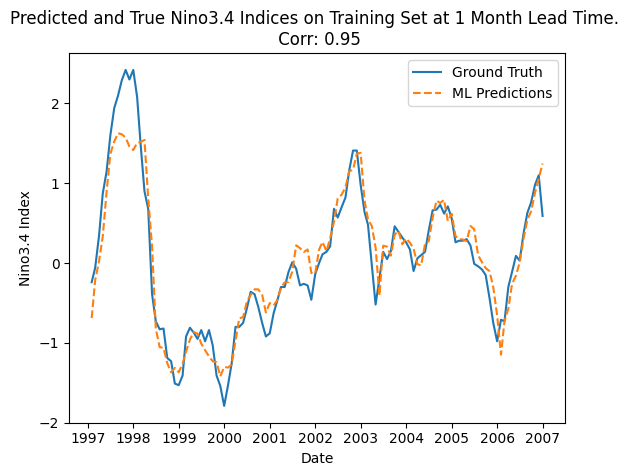

In [ ]:

#Let's use a linear regression model
rf_regr = sklearn.ensemble.RandomForestRegressor(n_estimators = 25)
rf_regr.fit(X_train,y_train)

rf_predictions = rf_regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(rf_predictions, y_val)
rmse = mean_squared_error(y_val, rf_predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, rf_predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

We compare our Random Forest against the linear regression:

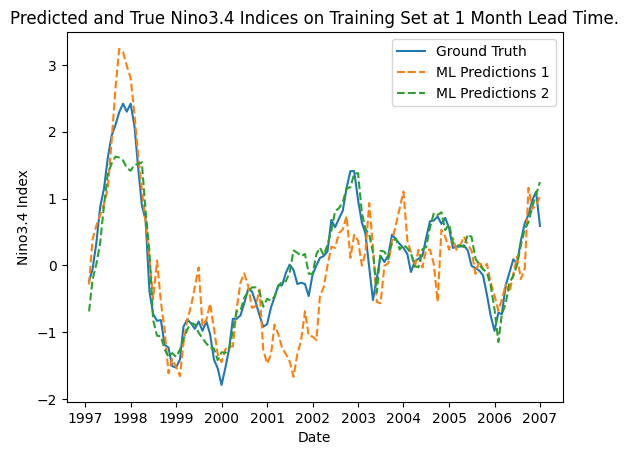

In [ ]:
plot_nino_time_series_comparison(y_val, l_predictions, rf_predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time.')

We see that the random forest model (ML predictions 2) already performs quite a bit better than the linear regression (ML predictions 1).

## Exercises

**Exercise 1:** Try changing the lead time in the code below. How does the prediction get better or worse?


**Exercise 2:** have a look at the documentation of the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) that we have used. This method has multiple so-called hyperparameters. Try modifying the `n_estimators` and `max_depth` parameters to different values in the code below. What happens?

**Exercise 3:** have a look at the [documentation of the scikit-learn ensemble module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble). Try out some other advanced machine learning methods in the code for example a `GradientBoostingRegressor` (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)). Does it perform better Fr worse?


In [ ]:
lead_time = 2

In [ ]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=lead_time)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=lead_time)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=lead_time)


RMSE: 0.17


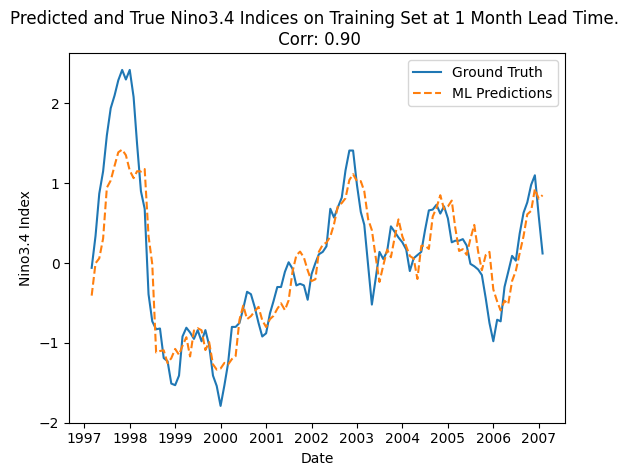

In [ ]:

#Let's use a linear regression model
rf_regr = sklearn.ensemble.RandomForestRegressor(n_estimators = 25)
rf_regr.fit(X_train,y_train)

rf_predictions = rf_regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(rf_predictions, y_val)
rmse = mean_squared_error(y_val, rf_predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, rf_predictions,
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

# Deep Learning

Now let's try training a neural network to forecast ENSO.  In this section, we will use PyTorch as our machine learning framework.



Let's get started: first, let's load the data. Please read the docstring for the `assemble_predictors_predictands` function! It is essential to understand the arguments to this function as we explore different scientific/ machine learning questions later on in this hackathon.

In this section, the `assemble_predictors_predictands` method has been extended to load in data from observations AND from GCMs.

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling


def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time,
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : 'sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : 'CNRM_tas_anomalies_regridded.nc',
               'MPI'          : 'MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")
  if lon_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")


  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)


    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead,
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

**Important info about `num_input_time_steps`:** `num_input_time_steps` refers to the number of time steps for each predictor.  For example, if `num_input_time_steps` is set to 3, then the machine learning model will take 3 months as its input.  In other words, a sample predictor will be 3 months of average temperature: Jan average temperature, Feb average temperature, and March average temperature (i.e. an array of (3, lat, lon)).  The predictand will be the Niño3.4 index `lead_time` months after March.

Let's define a simple convolutional neural network to start.  


## Train a simple Convolutional Neural Network (CNN) to forecast ENSO


Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [ ]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

Next, let's define a method that trains our neural network.  

Reading through this method will help you understand each step in the process of training a neural network.

Also, think about what would happen if you removed the lines that say `if mode == 'train'` in the code cell below.

In [ ]:
def train_network(net, criterion, optimizer, trainloader, testloader,
                  experiment_name, num_epochs=40):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()

          #Save the model weights that have the best performance!


          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))

  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)

  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses


In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.625801
test Set: Epoch 01. loss: 0.587422
train Set: Epoch 02. loss: 0.298671
test Set: Epoch 02. loss: 0.339697
train Set: Epoch 03. loss: 0.204817
test Set: Epoch 03. loss: 0.309281
train Set: Epoch 04. loss: 0.165465
test Set: Epoch 04. loss: 0.200976
train Set: Epoch 05. loss: 0.128927
test Set: Epoch 05. loss: 0.166951
train Set: Epoch 06. loss: 0.125665
test Set: Epoch 06. loss: 0.220636
train Set: Epoch 07. loss: 0.088846
test Set: Epoch 07. loss: 0.377980
train Set: Epoch 08. loss: 0.093889
test Set: Epoch 08. loss: 0.286489
train Set: Epoch 09. loss: 0.087963
test Set: Epoch 09. loss: 0.342683
train Set: Epoch 10. loss: 0.089377
test Set: Epoch 10. loss: 0.377117
train Set: Epoch 11. loss: 0.094936
test Set: Epoch 11. loss: 0.255279
train Set: Epoch 12. loss: 0.161112
test Set: Epoch 12. loss: 0.173107
train Set: Epoch 13. loss: 0.160085
test Set: Epoch 13. loss: 0.186771
train Set: Epoch 14. loss: 0.111588
test Set: Epoch 14. loss: 0.241833
train 

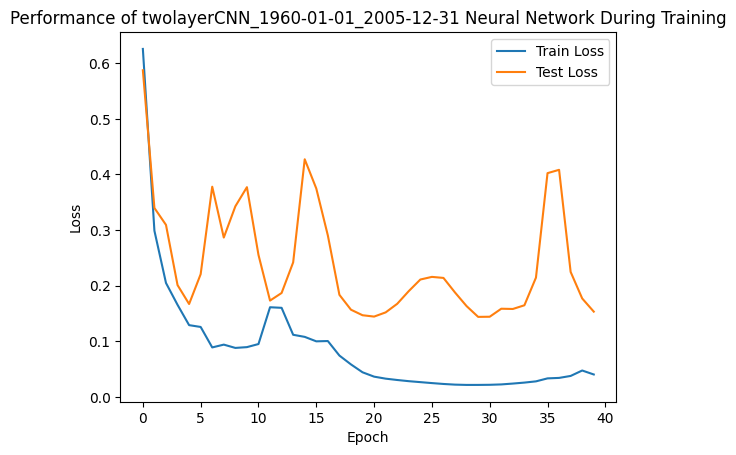

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

*Check your understanding:* From the previous section on fundamentals of machine learning, what is it called when the validation losses are very high and the train losses are very low?  What might we try to reduce this problem?

(Try reducing the number of parameters of the network.  You could define your own network architecture, which uses a different number of parameters!)

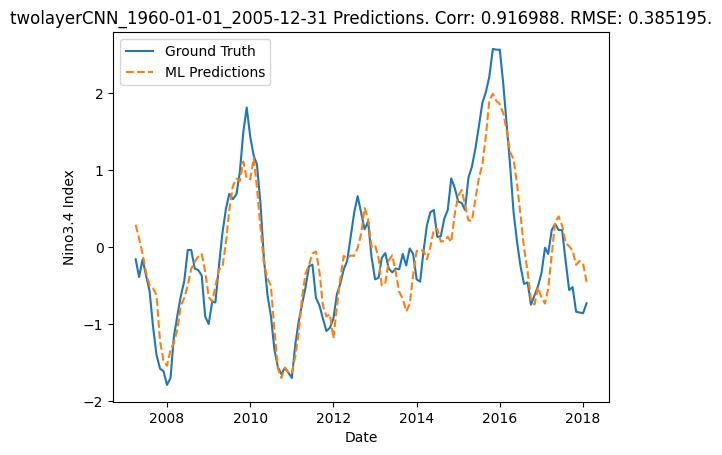

In [ ]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
                                                                      corr, rmse))

## Exercises

**Exercise 1:** Try modifying some parameters in the neural network above, like the number of layers or the number of parameters in each layer. Does the performance get better or worse?

# Bonus: The Bias-Variance Tradeoff

### Introduction and Theory

The behavior of machine learning models can be decomposed into two quantities:

*   **Bias**: On the training set, how well does the machine learning model predict the truth?
*   **Variance**: As the input data varies, how does the machine learning prediction vary?  For a small change in the input predictors, how much would the ML prediction change?

Let's look at the earlier figure once again:
![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


The left image uses a linear model to approximate a nonlinear "true function".  Therefore, the linear model does not understand the function well, and it has high bias.  Similarly, it has low variance, because small changes to sample points along the curve will not change the linear model must.


***Question***
1. Does the right image have high or low bias?
2. Does the right image have high or low variance?


Based on the figures above, we conclude that bias and variance are often a tradeoff: models with high bias often have low variance, and vice versa.  See page 23 of Nasiriany's notes for a mathematical derivation of this tradeoff.


Here's another example to help develop our visual understanding of bias vs. variance.

Here is how a k-Nearest-Neighbor model works:
1. The model is shown a sample data point from the test set, $x_\text{test}$
2. It searches its training set for the $k$ most similar data points
3. Of the $k$ points it founds, it calculates the most common predictand, and it assigns $x_\text{test}$ the most common

Crucially, this method supports classification of data that is not linearly separable (see below image for an example)

***Polling question:*** For a large value of $k$, would you expect a high bias/low variance classifier? Or a high variance/low bias classifier?

![alt text](http://web.cse.ohio-state.edu/~stiff.4/cse3521/images/effect-of-k.png)




Let's connect the bias/variance tradeoff to the discussion we had on overfitting in the first section. Implications of the bias-variance tradeoff (from Wikipedia)

*   "The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (**underfitting**)."

*   "The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (**overfitting**)."

### Regularization

Our goal in machine learning is to avoid underfitting and overfitting: we want to develop models that perform well in both the train set and the test set.

One method to avoid overfitting is **regularization.** In the next section, we will discuss how regularization avoids overfitting.  

Let $X$ be a 2D matrix of shape $(n,d)$ where $n$ is the number of time steps and $d$ is the number of predictors.  Let $y$ be a vector of shape $(n,1)$ that has the target ENSO values.  Let $w$ be a vector of shape $(d,1)$

In ordinary least squares linear regression, we are **finding the value of $w$** that minimizes the following term:

$$\text{min}||Xw-y||^2 $$


Here's an intuitive description of the math above:
*   the goal of linear regression is to minimize the squared difference between the linear models' predictions ($Xw$) and the truth ($y$).

The forecast of a linear regression model is $Xw$.  Here's an intuitive description of what $Xw$:
*   a linear regression model makes a forecast by multiplying each predictor by its associated weight and returning the sum of these products. With  large weights, a small change in one of the predictors will lead to a large change in the forecast.  Therefore, we amend linear regression to penalize the model from learning large weights:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ is called a regularization term. This regularized form of linear regression is often called **Ridge Regression**.

Please see pg. 6 of Nasiriany for mathematical derivations to the solutions of the above two minimization problems.


### *Coding Exercise*: Regularization


In this example, we will investigate the real-world effect of regularization on our ENSO dataset.

Note: for visualization purposes, we do not train our models using all lat$*$lon predictors.  Instead, we use Principal Components Analysis (aka Empirical Orthogonal Functionals) to represent all lat$*$lon predictors with far fewer dimensions.  Due to time constraints, please refer to page 116 of Professor Shewchuk's notes for a deeper explanation of this method.

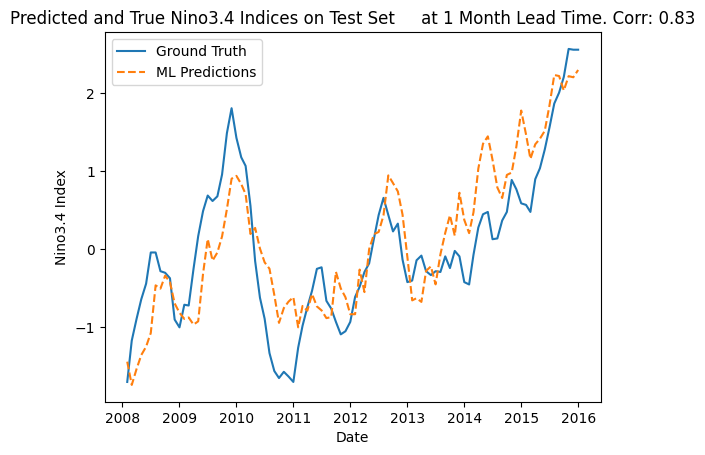

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


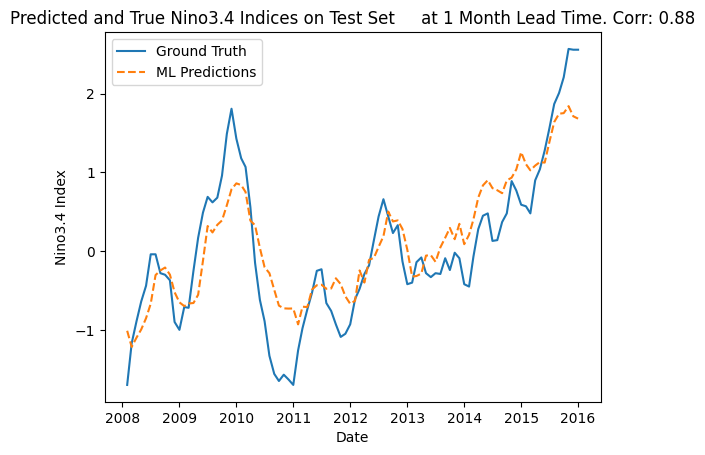

In [ ]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31',
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


On the test set we see that the regularized model performs slightly better than the linear model! This is a good sign, as the goal of regularization is to develop models that can better **generalize** to unseen data.

Next, let's visualize and compare the variance of the two models.  Recall that models that are highly variable are susceptable to small fluctuations in the predictors.  In the code cell below, we conduct the experiment:


*   Perturb the test set predictors by multiplying them by a random number between -1.05 and 1.05
*   Run the trained ridge regression and linear regression models on those perturbed predictors
*   Record the spread in the predictions

The spread of these predictions is the variance of the ML model.

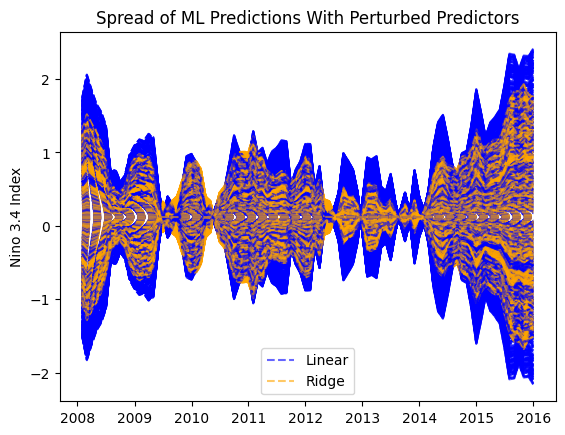

In [ ]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)

  perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

The plot above illustrates the effect of regularization!  When randomly perturbing the input 1000 times, the predictions from linear regression (blue) have a larger spread than those from ridge regression (orange).  This means that linear regression has a higher variance than ridge regression.  

In the cell below, let's investigate why ridge regression is less vulnerable to small fluctuations in the data.

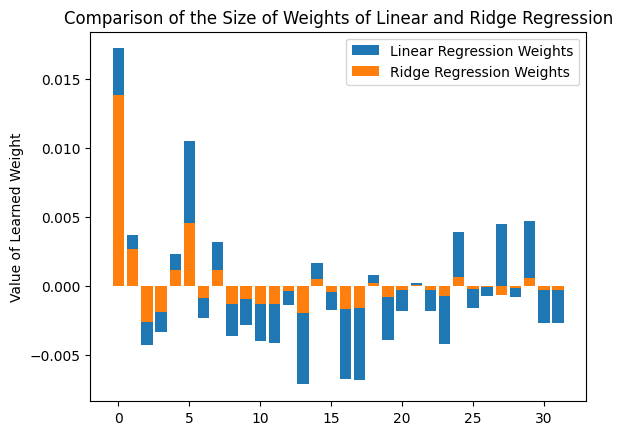

In [ ]:
"""In this cell, we will visualize how the weights of the linear
regression model are bigger than those of the ridge regression model"""

#coef_ loads in the coefficients from the trained model
regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights')
plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Ridge Regression Weights')
plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of the Size of Weights of Linear and Ridge Regression')
plt.show()

As expected, the weights of the ridge regression model are smaller than those of the linear regression model.

There we have it! On our real-world ENSO dataset, we have confirmed our theoretical speculations about the effect of regularization on the bias-variance tradeoff!  

To recap:

*   Because of the regularization term, the weights in a ridge regression model are smaller (large weights are penalized during the optimization) than those in linear regression
*   With smaller weights, the ridge regression model is less vulnerable to small fluctuations in the data
*   This means that ridge regression models have less variance and are less vulnerable to overfitting